In [116]:
import numpy as np
import pandas as pd
from collections import defaultdict
from kmodes.kmodes import KModes
from matplotlib import pyplot as plt
from prince import FAMD, MCA
from sklearn import datasets, decomposition
from sklearn import cluster as cl

In [117]:
data_customers = pd.read_csv('Data/twm_customer.csv',sep=';')
data_accounts = pd.read_csv('Data/twm_accounts.csv',sep=';')
data_transactions = pd.read_csv('Data/twm_transactions.csv',sep=';')

In [118]:
# Function to strip whitepsace from ends of string, but will take any input and return it if it's not a string
def fix(input):
    try:
        input = input.strip()
    except:
        pass
    return input

In [119]:
# Fix all the dataframes, removing whitespace from start and end of strings

for colname in data_customers.columns:
    data_customers[colname] = data_customers[colname].apply(fix)

for colname in data_accounts.columns:
    data_accounts[colname] = data_accounts[colname].apply(fix)

for colname in data_transactions.columns:
    data_transactions[colname] = data_transactions[colname].apply(fix)

In [120]:
# Gather relevant data from accounts and link it to customers with dicts
accounts_to_customer = {}
account_type = {}
customer_to_accounts = defaultdict(list)
customer_to_total_balance = defaultdict(dict)

for row in data_accounts.iterrows():
    row = row[1]
    acct_num, cust_id, acct_type = row.acct_nbr, row.cust_id, row.acct_type
    balance = row.ending_balance if row.account_active == 'Y' else 0
    if acct_type == 'CC':
        balance *= -1
    if acct_num not in accounts_to_customer:
        accounts_to_customer[acct_num] = cust_id
    else:
        print('Duplicate account number found: %s' % acct_num)
    account_type[acct_num] = acct_type
    customer_to_accounts[cust_id].append(acct_type)
    customer_to_total_balance[cust_id][acct_type] = balance

In [121]:
# Add a columns for customer's current total balance

data_customers['total_balance'] = [ sum(customer_to_total_balance[x].values()) if x in customer_to_total_balance else 0
                                    for x in data_customers.cust_id ]

data_customers['cc_balance'] = [ customer_to_total_balance[x]['CC'] if x in customer_to_total_balance and 'CC' in customer_to_total_balance[x] else 0
                                 for x in data_customers.cust_id ]

data_customers['ck_balance'] = [ customer_to_total_balance[x]['CK'] if x in customer_to_total_balance and 'CK' in customer_to_total_balance[x] else 0
                                 for x in data_customers.cust_id ]

data_customers['sv_balance'] = [ customer_to_total_balance[x]['SV'] if x in customer_to_total_balance and 'SV' in customer_to_total_balance[x] else 0
                                 for x in data_customers.cust_id ]

# Add categorical variables with 0/1 values for whether customer has a certain type of account

data_customers['has_savings_acct'] = [ 1 if x in customer_to_accounts and 'SV' in customer_to_accounts[x] else 0
                                       for x in data_customers.cust_id ]

data_customers['has_credit_card'] = [ 1 if x in customer_to_accounts and 'CC' in customer_to_accounts[x] else 0
                                       for x in data_customers.cust_id ]

data_customers['has_checking_acct'] = [ 1 if x in customer_to_accounts and 'CK' in customer_to_accounts[x] else 0
                                       for x in data_customers.cust_id ]

In [123]:
# Gather relevant data for transactions and link it back to customers with dicts

customer_to_n_trans = defaultdict(int)
customer_to_n_trans_sv = defaultdict(int)
customer_to_n_trans_cc = defaultdict(int)
customer_to_n_trans_ck = defaultdict(int)
customer_to_deposits = defaultdict(list)
customer_to_withdrawals = defaultdict(list)
customer_to_deposits_sv = defaultdict(list)
customer_to_deposits_cc = defaultdict(list)
customer_to_deposits_ck = defaultdict(list)
customer_to_withdrawals_sv = defaultdict(list)
customer_to_withdrawals_cc = defaultdict(list)
customer_to_withdrawals_ck = defaultdict(list)

for row in data_transactions.iterrows():
    row = row[1]
    if row.acct_nbr not in accounts_to_customer: # Some account numbers in data_transactions were not in data_accounts
        continue
    cust_id = accounts_to_customer[row.acct_nbr]
    acct_type = account_type[row.acct_nbr]
    amnt = row.tran_amt
    if amnt < 0:
        customer_to_withdrawals[cust_id].append(abs(amnt))
        customer_to_n_trans[cust_id] += 1
        if acct_type == 'SV':
            customer_to_withdrawals_sv[cust_id].append(abs(amnt))
            customer_to_n_trans_sv[cust_id] += 1
        elif acct_type == 'CC':
            customer_to_withdrawals_cc[cust_id].append(abs(amnt))
            customer_to_n_trans_cc[cust_id] += 1
        elif acct_type == 'CK':
            customer_to_withdrawals_ck[cust_id].append(abs(amnt))
            customer_to_n_trans_ck[cust_id] += 1
    else:
        customer_to_deposits[cust_id].append(amnt)
        customer_to_n_trans[cust_id] += 1
        if acct_type == 'SV':
            customer_to_deposits_sv[cust_id].append(abs(amnt))
            customer_to_n_trans_sv[cust_id] += 1
        elif acct_type == 'CC':
            customer_to_deposits_cc[cust_id].append(abs(amnt))
            customer_to_n_trans_cc[cust_id] += 1
        elif acct_type == 'CK':
            customer_to_deposits_ck[cust_id].append(abs(amnt))
            customer_to_n_trans_ck[cust_id] += 1

In [124]:
# Add some columns to the customer data for transactions

data_customers['max_deposit'] = [ np.max(customer_to_deposits[x]) if x in customer_to_deposits else 0
                                  for x in data_customers.cust_id]

data_customers['avg_deposit'] = [ np.mean(customer_to_deposits[x]) if x in customer_to_deposits else 0
                                  for x in data_customers.cust_id]

data_customers['max_withdrawal'] = [ np.max(customer_to_withdrawals[x]) if x in customer_to_withdrawals else 0
                                  for x in data_customers.cust_id]

data_customers['avg_withdrawal'] = [ np.mean(customer_to_withdrawals[x]) if x in customer_to_withdrawals else 0
                                  for x in data_customers.cust_id]




data_customers['transaction_count'] = [ customer_to_n_trans[x] if x in customer_to_n_trans else 0
                                         for x in data_customers.cust_id ]

data_customers['transaction_count_sv'] = [ customer_to_n_trans_sv[x] if x in customer_to_n_trans_sv else 0
                                         for x in data_customers.cust_id ]

data_customers['transaction_count_cc'] = [ customer_to_n_trans_cc[x] if x in customer_to_n_trans_cc else 0
                                         for x in data_customers.cust_id ]

data_customers['transaction_count_ck'] = [ customer_to_n_trans_ck[x] if x in customer_to_n_trans_ck else 0
                                         for x in data_customers.cust_id ]




data_customers['max_deposit_sv'] = [ np.max(customer_to_deposits_sv[x]) if x in customer_to_deposits_sv else 0
                                  for x in data_customers.cust_id]

data_customers['avg_deposit_sv'] = [ np.mean(customer_to_deposits_sv[x]) if x in customer_to_deposits_sv else 0
                                  for x in data_customers.cust_id]

data_customers['max_withdrawal_sv'] = [ np.max(customer_to_withdrawals_sv[x]) if x in customer_to_withdrawals_sv else 0
                                  for x in data_customers.cust_id]

data_customers['avg_withdrawal_sv'] = [ np.mean(customer_to_withdrawals_sv[x]) if x in customer_to_withdrawals_sv else 0
                                  for x in data_customers.cust_id]




data_customers['max_deposit_cc'] = [ np.max(customer_to_deposits_cc[x]) if x in customer_to_deposits_cc else 0
                                  for x in data_customers.cust_id]

data_customers['avg_deposit_cc'] = [ np.mean(customer_to_deposits_cc[x]) if x in customer_to_deposits_cc else 0
                                  for x in data_customers.cust_id]

data_customers['max_withdrawal_cc'] = [ np.max(customer_to_withdrawals_cc[x]) if x in customer_to_withdrawals_cc else 0
                                  for x in data_customers.cust_id]

data_customers['avg_withdrawal_cc'] = [ np.mean(customer_to_withdrawals_cc[x]) if x in customer_to_withdrawals_cc else 0
                                  for x in data_customers.cust_id]




data_customers['max_deposit_ck'] = [ np.max(customer_to_deposits_ck[x]) if x in customer_to_deposits_ck else 0
                                  for x in data_customers.cust_id]

data_customers['avg_deposit_ck'] = [ np.mean(customer_to_deposits_ck[x]) if x in customer_to_deposits_ck else 0
                                  for x in data_customers.cust_id]

data_customers['max_withdrawal_ck'] = [ np.max(customer_to_withdrawals_ck[x]) if x in customer_to_withdrawals_ck else 0
                                  for x in data_customers.cust_id]

data_customers['avg_withdrawal_ck'] = [ np.mean(customer_to_withdrawals_ck[x]) if x in customer_to_withdrawals_ck else 0
                                  for x in data_customers.cust_id]





In [126]:
data_customers.columns

Index(['cust_id', 'income', 'age', 'years_with_bank', 'nbr_children', 'gender',
       'marital_status', 'name_prefix', 'first_name', 'last_name',
       'street_nbr', 'street_name', 'postal_code', 'city_name', 'state_code',
       'total_balance', 'cc_balance', 'ck_balance', 'sv_balance',
       'has_savings_acct', 'has_credit_card', 'has_checking_acct',
       'max_deposit', 'avg_deposit', 'max_withdrawal', 'avg_withdrawal',
       'transaction_count', 'transaction_count_sv', 'transaction_count_cc',
       'transaction_count_ck', 'max_deposit_sv', 'avg_deposit_sv',
       'max_withdrawal_sv', 'avg_withdrawal_sv', 'max_deposit_cc',
       'avg_deposit_cc', 'max_withdrawal_cc', 'avg_withdrawal_cc',
       'max_deposit_ck', 'avg_deposit_ck', 'max_withdrawal_ck',
       'avg_withdrawal_ck'],
      dtype='object')

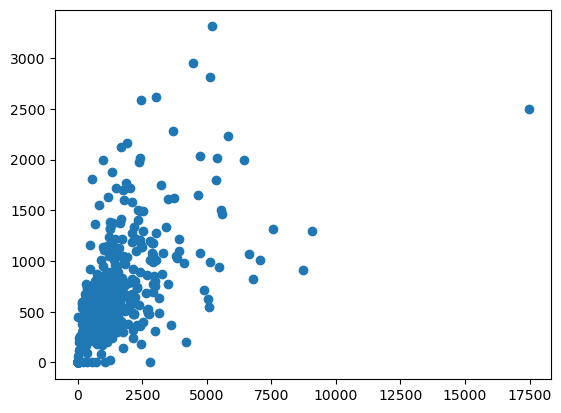

In [83]:
plt.scatter(data_customers.max_deposit,data_customers.max_withdrawal)

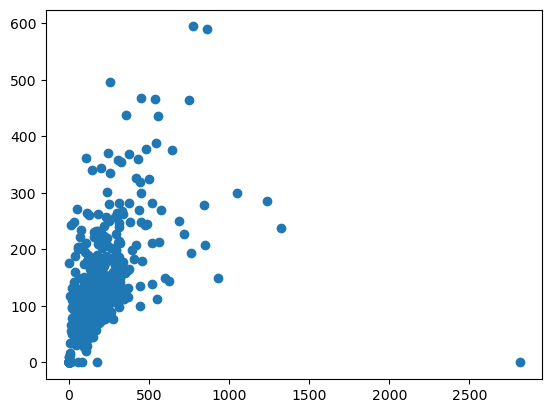

In [84]:
plt.scatter(data_customers.avg_deposit,data_customers.avg_withdrawal)

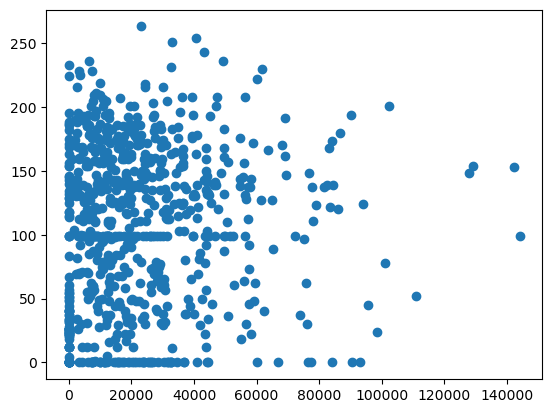

In [85]:
plt.scatter(data_customers.income,data_customers.avg_trans_per_year)

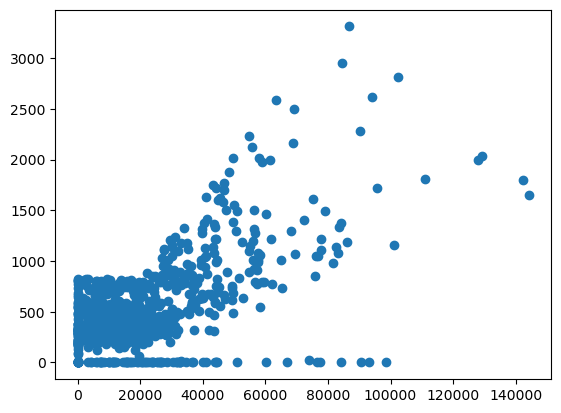

In [86]:
plt.scatter(data_customers.income,data_customers.max_withdrawal)

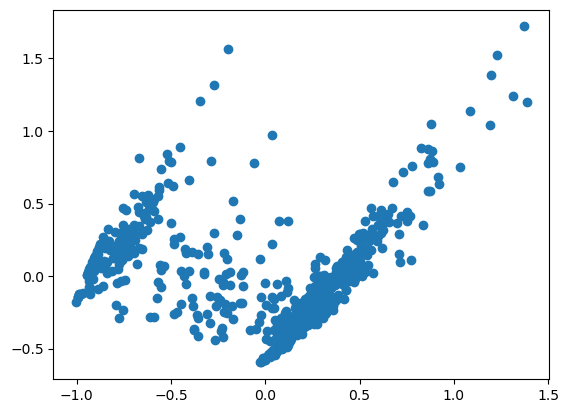

In [138]:
data = data_customers[['income','age','total_balance', 'cc_balance', 'ck_balance', 'sv_balance','max_deposit', 'avg_deposit', 'max_withdrawal', 'avg_withdrawal', 'transaction_count', 'transaction_count_sv', 'transaction_count_cc',
                       'transaction_count_ck', 'max_deposit_sv', 'avg_deposit_sv', 'max_withdrawal_sv', 'avg_withdrawal_sv', 'max_deposit_cc', 'avg_deposit_cc', 'max_withdrawal_cc', 'avg_withdrawal_cc','max_deposit_ck', 'avg_deposit_ck',
                       'max_withdrawal_ck', 'avg_withdrawal_ck']]

data = data[data.transaction_count > 0]

for col in data.columns:
    data[col] = np.abs(data[col])
    data[col] = data[col] / np.max(data[col])

pca = decomposition.PCA(n_components=2)
pca.fit(data)
transformed = pca.transform(data)
var_percent = pca.explained_variance_ratio_ * 100

plt.scatter(transformed[:,0],transformed[:,1])

In [88]:
var_percent

array([41.25490511, 12.14155883])

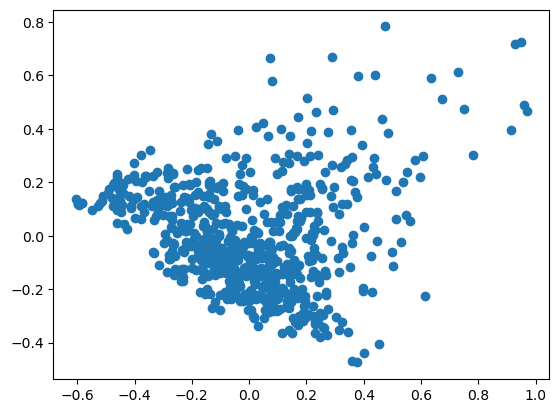

In [89]:
data = data_customers[['income','age','max_deposit','avg_deposit','max_withdrawal','avg_withdrawal',
                       'avg_trans_per_year','total_balance']]

data = data[data.avg_trans_per_year > 0]

for col in data.columns:
    data[col] = data[col] / np.max(data[col])

pca = decomposition.PCA(n_components=2)
pca.fit(data)
transformed = pca.transform(data)
var_percent = pca.explained_variance_ratio_ * 100

plt.scatter(transformed[:,0],transformed[:,1])

In [90]:
min(data.total_balance)

-0.34164346064082596

In [91]:
var_percent

array([39.3937811 , 24.11322499])

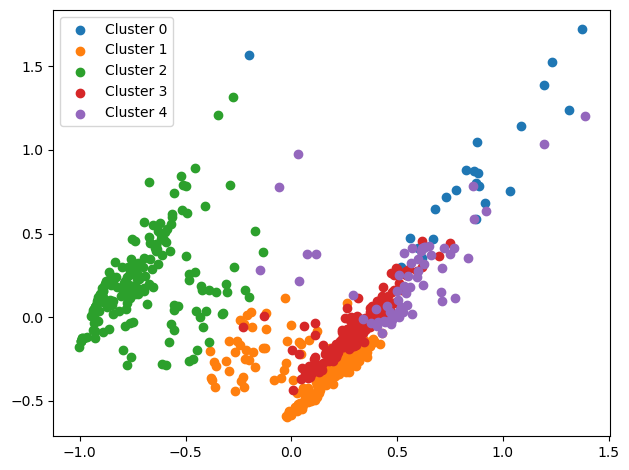

In [139]:
N = 5
clusters = cl.KMeans(n_clusters=N,random_state=None).fit(data).labels_

for n in range(N):
    X = transformed[:,0][clusters == n]
    Y = transformed[:,1][clusters == n]
    plt.scatter(X,Y,label=f'Cluster {n}')

plt.legend()
plt.tight_layout()

In [175]:
print(pca.explained_variance_ratio_)

print()
for i, col in enumerate(data.columns):
    print(col,coeff[i])

[0.4019954  0.24522738]

income [0.41252075 0.44848502]
age [ 0.47530083 -0.21204094]
total_balance [0.09785089 0.10517966]
max_deposit [0.18486706 0.09626615]
avg_deposit [0.11427393 0.10307392]
max_withdrawal [0.40680252 0.25031125]
avg_withdrawal [0.32730834 0.42164052]
transaction_count [ 0.5239156  -0.69462883]


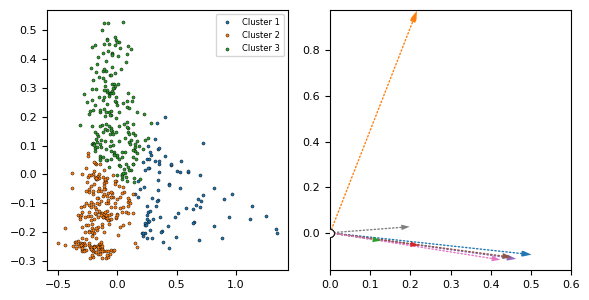

In [192]:
# data = data_customers[['income','age','total_balance', 'cc_balance', 'ck_balance', 'sv_balance','max_deposit', 'avg_deposit', 'max_withdrawal', 'avg_withdrawal', 'transaction_count', 'transaction_count_sv', 'transaction_count_cc',
#                        'transaction_count_ck', 'max_deposit_sv', 'avg_deposit_sv', 'max_withdrawal_sv', 'avg_withdrawal_sv', 'max_deposit_cc', 'avg_deposit_cc', 'max_withdrawal_cc', 'avg_withdrawal_cc','max_deposit_ck', 'avg_deposit_ck',
#                        'max_withdrawal_ck', 'avg_withdrawal_ck']]

data = data_customers[['income','age','total_balance', 'max_deposit', 'avg_deposit', 'max_withdrawal', 'avg_withdrawal', 'transaction_count']]


data = data[data_customers.transaction_count_ck > 0]
data = data[data.transaction_count > 0]

for col in data.columns:
    data[col] = np.abs(data[col])
    data[col] = data[col] / np.max(data[col])

pca = decomposition.PCA(n_components=2)
pca.fit(data)
transformed = pca.transform(data)
var_percent = pca.explained_variance_ratio_ * 100    
    
N = 3
clusters = cl.KMeans(n_clusters=N,random_state=None).fit(data).labels_
epsilon = 0.05

fig, axes = plt.subplots(1,2)

ax = axes[0]

for n in range(N):
    X = transformed[:,0][clusters == n]
    Y = transformed[:,1][clusters == n]
    ax.scatter(X,Y,label=f'Cluster {n+1}',s=5,edgecolor=(0,0,0),linewidth=0.3)

ax.legend(fontsize=6)
ax.tick_params(labelsize=8)

ax = axes[1]

coeff = pca.components_.T

for i in range(len(coeff)):
    p = ax.plot((0,coeff[i,0]-(coeff[i,0]*epsilon)),(0,coeff[i,1]-(coeff[i,1]*epsilon)),
                linestyle='dotted',label=data.columns[i],linewidth=1,dash_capstyle='round')
    ax.scatter(0,0,s=30,color='white',edgecolor='black',linewidth=0.5,zorder=10)
    ax.annotate('',xy=(coeff[i,0],coeff[i,1]),xytext=(coeff[i,0]-(coeff[i,0]*epsilon),coeff[i,1]-(coeff[i,1]*epsilon)),
                arrowprops=dict(facecolor=p[0].get_color(),headwidth=4,headlength=6,linewidth=0))

    
# ax.legend(loc='lower left',fontsize=6)
ax.tick_params(labelsize=8)
ax.set_xlim((0,0.6))

fig.set_figheight(3.1)
fig.set_figwidth(6)
    
plt.tight_layout()
plt.savefig('PCA_Aggregate_with_Zero_CK_Activity_Removed.pdf')

In [193]:
print(pca.explained_variance_ratio_)

print()
for i, col in enumerate(data.columns):
    print(col,coeff[i])

[0.44158112 0.24160663]

income [ 0.50120168 -0.09551849]
age [0.21610439 0.97340064]
total_balance [ 0.12651854 -0.03441349]
max_deposit [ 0.22096195 -0.05506681]
avg_deposit [ 0.46309527 -0.11414523]
max_withdrawal [ 0.45170215 -0.10693544]
avg_withdrawal [ 0.4237546  -0.11820374]
transaction_count [0.19800154 0.02672685]


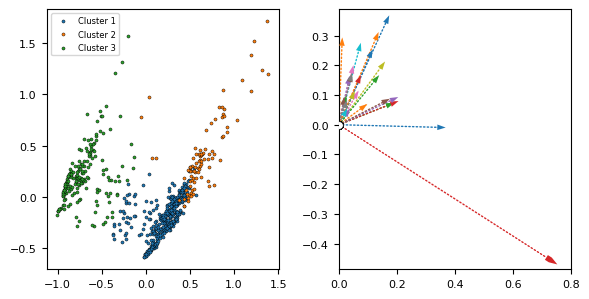

In [186]:
data = data_customers[['income','age','total_balance', 'cc_balance', 'ck_balance', 'sv_balance','max_deposit', 'avg_deposit', 'max_withdrawal', 'avg_withdrawal', 'transaction_count', 'transaction_count_sv', 'transaction_count_cc',
                       'transaction_count_ck', 'max_deposit_sv', 'avg_deposit_sv', 'max_withdrawal_sv', 'avg_withdrawal_sv', 'max_deposit_cc', 'avg_deposit_cc', 'max_withdrawal_cc', 'avg_withdrawal_cc','max_deposit_ck', 'avg_deposit_ck',
                       'max_withdrawal_ck', 'avg_withdrawal_ck']]

# data = data_customers[['income','age','total_balance', 'max_deposit', 'avg_deposit', 'max_withdrawal', 'avg_withdrawal', 'transaction_count']]

data = data[data.transaction_count > 0]

for col in data.columns:
    data[col] = np.abs(data[col])
    data[col] = data[col] / np.max(data[col])

pca = decomposition.PCA(n_components=2)
pca.fit(data)
transformed = pca.transform(data)
var_percent = pca.explained_variance_ratio_ * 100    
    
N = 3
clusters = cl.KMeans(n_clusters=N,random_state=None).fit(data).labels_
epsilon = 0.05

fig, axes = plt.subplots(1,2)

ax = axes[0]

for n in range(N):
    X = transformed[:,0][clusters == n]
    Y = transformed[:,1][clusters == n]
    ax.scatter(X,Y,label=f'Cluster {n+1}',s=5,edgecolor=(0,0,0),linewidth=0.3)

ax.legend(fontsize=6)
ax.tick_params(labelsize=8)

ax = axes[1]

coeff = pca.components_.T

for i in range(len(coeff)):
    p = ax.plot((0,coeff[i,0]-(coeff[i,0]*epsilon)),(0,coeff[i,1]-(coeff[i,1]*epsilon)),
                linestyle='dotted',label=data.columns[i],linewidth=1,dash_capstyle='round')
    ax.scatter(0,0,s=30,color='white',edgecolor='black',linewidth=0.5,zorder=10)
    ax.annotate('',xy=(coeff[i,0],coeff[i,1]),xytext=(coeff[i,0]-(coeff[i,0]*epsilon),coeff[i,1]-(coeff[i,1]*epsilon)),
                arrowprops=dict(facecolor=p[0].get_color(),headwidth=4,headlength=6,linewidth=0))

    
# ax.legend(loc='lower left',fontsize=6)
ax.tick_params(labelsize=8)
ax.set_xlim((0,0.8))

fig.set_figheight(3.1)
fig.set_figwidth(6)
    
plt.tight_layout()
plt.savefig('PCA_Agg_and_Acct_Specific.pdf')

In [188]:
print(pca.explained_variance_ratio_)

print()
for i, col in enumerate(data.columns):
    print(col,coeff[i])

[0.39030254 0.17912043]

income [0.11613515 0.25350622]
age [0.09784357 0.06971258]
total_balance [0.02581866 0.09815888]
cc_balance [0.07602884 0.16741077]
ck_balance [0.03852329 0.0542227 ]
sv_balance [0.01904842 0.09398439]
max_deposit [0.06782015 0.11478313]
avg_deposit [0.0280278  0.08383244]
max_withdrawal [0.15908782 0.21279998]
avg_withdrawal [0.0754847  0.27583759]
transaction_count [ 0.36774377 -0.00949406]
transaction_count_sv [0.01150804 0.29386572]
transaction_count_cc [0.13877312 0.16682179]
transaction_count_ck [ 0.75245738 -0.47044434]
max_deposit_sv [0.0367891  0.16459575]
avg_deposit_sv [0.04438952 0.17185501]
max_withdrawal_sv [0.05005035 0.20047567]
avg_withdrawal_sv [0.04531036 0.17457595]
max_deposit_cc [0.05520762 0.11365003]
avg_deposit_cc [0.0282797  0.05509121]
max_withdrawal_cc [0.17332915 0.36811991]
avg_withdrawal_cc [0.13678597 0.31210434]
max_deposit_ck [0.19040265 0.07387306]
avg_deposit_ck [0.20531064 0.07963009]
max_withdrawal_ck [0.20435947 0.09316259

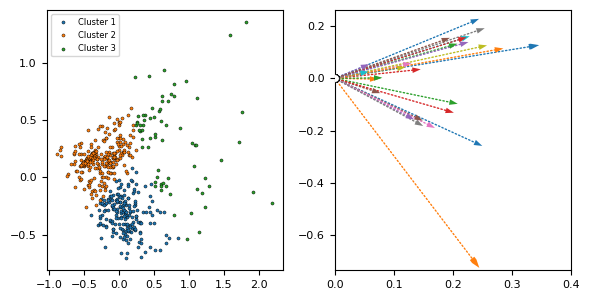

In [190]:
data = data_customers[['income','age','total_balance', 'cc_balance', 'ck_balance', 'sv_balance','max_deposit', 'avg_deposit', 'max_withdrawal', 'avg_withdrawal', 'transaction_count', 'transaction_count_sv', 'transaction_count_cc',
                       'transaction_count_ck', 'max_deposit_sv', 'avg_deposit_sv', 'max_withdrawal_sv', 'avg_withdrawal_sv', 'max_deposit_cc', 'avg_deposit_cc', 'max_withdrawal_cc', 'avg_withdrawal_cc','max_deposit_ck', 'avg_deposit_ck',
                       'max_withdrawal_ck', 'avg_withdrawal_ck']]

# data = data_customers[['income','age','total_balance', 'max_deposit', 'avg_deposit', 'max_withdrawal', 'avg_withdrawal', 'transaction_count']]

data = data[data.transaction_count > 0]
data = data[data.transaction_count_ck > 0]

for col in data.columns:
    data[col] = np.abs(data[col])
    data[col] = data[col] / np.max(data[col])

pca = decomposition.PCA(n_components=2)
pca.fit(data)
transformed = pca.transform(data)
var_percent = pca.explained_variance_ratio_ * 100    
    
N = 3
clusters = cl.KMeans(n_clusters=N,random_state=None).fit(data).labels_
epsilon = 0.05

fig, axes = plt.subplots(1,2)

ax = axes[0]

for n in range(N):
    X = transformed[:,0][clusters == n]
    Y = transformed[:,1][clusters == n]
    ax.scatter(X,Y,label=f'Cluster {n+1}',s=5,edgecolor=(0,0,0),linewidth=0.3)

ax.legend(fontsize=6)
ax.tick_params(labelsize=8)

ax = axes[1]

coeff = pca.components_.T

for i in range(len(coeff)):
    p = ax.plot((0,coeff[i,0]-(coeff[i,0]*epsilon)),(0,coeff[i,1]-(coeff[i,1]*epsilon)),
                linestyle='dotted',label=data.columns[i],linewidth=1,dash_capstyle='round')
    ax.scatter(0,0,s=30,color='white',edgecolor='black',linewidth=0.5,zorder=10)
    ax.annotate('',xy=(coeff[i,0],coeff[i,1]),xytext=(coeff[i,0]-(coeff[i,0]*epsilon),coeff[i,1]-(coeff[i,1]*epsilon)),
                arrowprops=dict(facecolor=p[0].get_color(),headwidth=4,headlength=6,linewidth=0))

    
# ax.legend(loc='lower left',fontsize=6)
ax.tick_params(labelsize=8)
ax.set_xlim((0,0.4))

fig.set_figheight(3.1)
fig.set_figwidth(6)
    
plt.tight_layout()
plt.savefig('PCA_Agg_and_Acct_Specific_With_Zero_CK_Activity_Removed.pdf')

In [191]:
print(pca.explained_variance_ratio_)

print()
for i, col in enumerate(data.columns):
    print(col,coeff[i])

[0.33369297 0.18983786]

income [0.24412506 0.22809172]
age [ 0.07364107 -0.00274804]
total_balance [0.08048098 0.00240305]
cc_balance [0.14542866 0.03482436]
ck_balance [0.05822552 0.05426818]
sv_balance [ 0.07709862 -0.05639248]
max_deposit [0.13010458 0.0586678 ]
avg_deposit [0.25378131 0.19225296]
max_withdrawal [0.25772603 0.12651235]
avg_withdrawal [0.22839379 0.16155878]
transaction_count [ 0.24964897 -0.25847252]
transaction_count_sv [ 0.24465388 -0.72566084]
transaction_count_cc [ 0.20805179 -0.09719138]
transaction_count_ck [ 0.20155242 -0.13133598]
max_deposit_sv [ 0.13423454 -0.15738348]
avg_deposit_sv [ 0.149004   -0.16174222]
max_withdrawal_sv [ 0.16957655 -0.18979559]
avg_withdrawal_sv [ 0.14960717 -0.18215932]
max_deposit_cc [0.11971998 0.0432388 ]
avg_deposit_cc [0.05741196 0.02603227]
max_withdrawal_cc [0.34590422 0.12746259]
avg_withdrawal_cc [0.2852724  0.11476539]
max_deposit_ck [0.20750607 0.13278311]
avg_deposit_ck [0.22309346 0.15745469]
max_withdrawal_ck [0.226

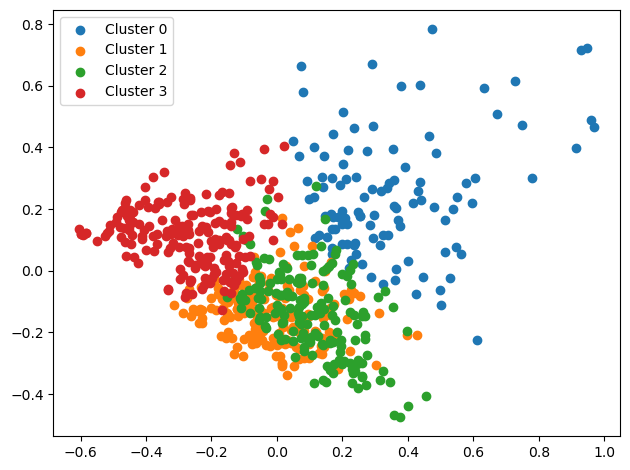

In [94]:
N = 4
clusters = cl.KMeans(n_clusters=N,random_state=None).fit(data).labels_

for n in range(N):
    X = transformed[:,0][clusters == n]
    Y = transformed[:,1][clusters == n]
    plt.scatter(X,Y,label=f'Cluster {n}')

plt.legend()
plt.tight_layout()

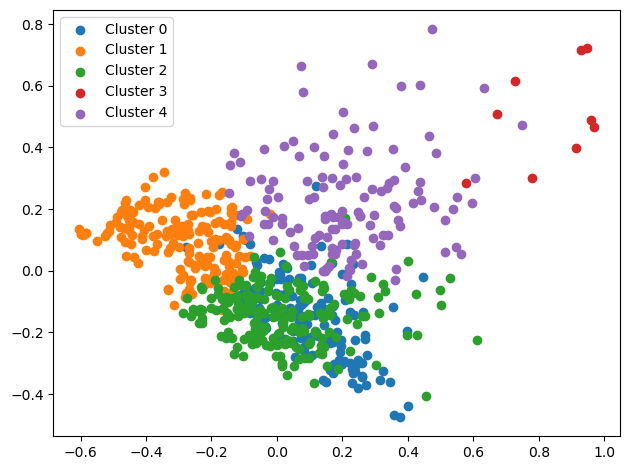

In [95]:
N = 5
clusters = cl.SpectralClustering(n_clusters=N,random_state=None).fit(data).labels_

for n in range(N):
    X = transformed[:,0][clusters == n]
    Y = transformed[:,1][clusters == n]
    plt.scatter(X,Y,label=f'Cluster {n}')

plt.legend()
plt.tight_layout()

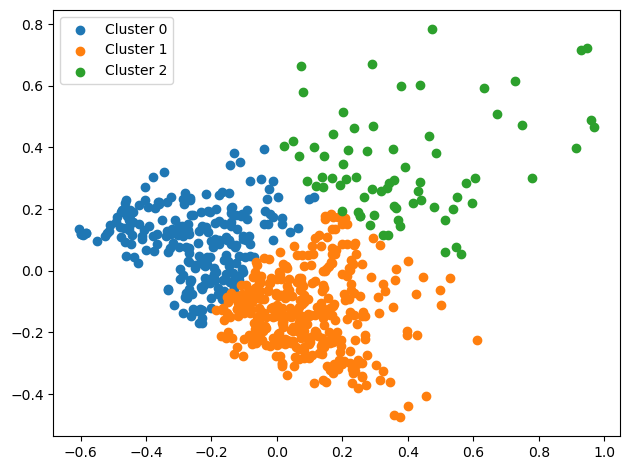

In [96]:
N = 3
clusters = cl.SpectralClustering(n_clusters=N,random_state=None).fit(data).labels_

for n in range(N):
    X = transformed[:,0][clusters == n]
    Y = transformed[:,1][clusters == n]
    plt.scatter(X,Y,label=f'Cluster {n}')

plt.legend()
plt.tight_layout()

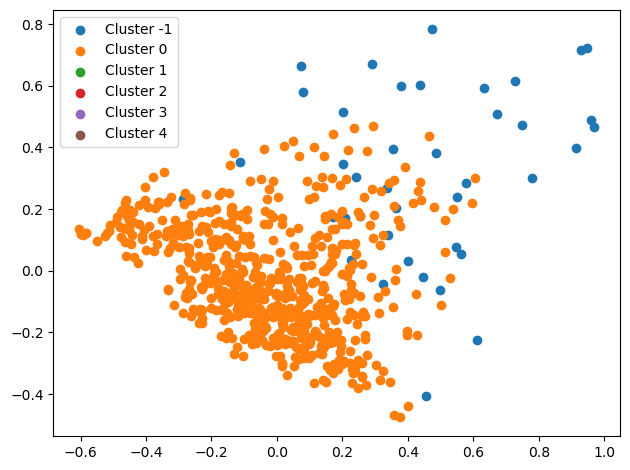

In [97]:
N = 5
clusters = cl.DBSCAN(eps=0.25).fit(data).labels_

for n in range(-1,N):
    X = transformed[:,0][clusters == n]
    Y = transformed[:,1][clusters == n]
    plt.scatter(X,Y,label=f'Cluster {n}')

plt.legend()
plt.tight_layout()

In [98]:
data_customers

,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,first_name,last_name,...,max_withdrawal_sv,avg_withdrawal_sv,max_deposit_cc,avg_deposit_cc,max_withdrawal_cc,avg_withdrawal_cc,max_deposit_ck,avg_deposit_ck,max_withdrawal_ck,avg_withdrawal_ck
0,1362691,26150,46,5,1,M,2,,Donald,Marek,...,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000
1,1362487,6605,71,1,0,M,2,,ChingDyi,Moussavi,...,204.66,109.025714,588.77,269.801667,254.98,121.323077,680.98,46.653500,206.52,72.242500
2,1363160,18548,38,8,0,F,1,,Rosa,Johnston,...,284.81,66.318000,774.71,402.718125,239.73,116.605000,0.00,0.000000,0.00,0.000000
3,1362752,47668,54,3,0,F,1,,Lisa,Martin,...,0.00,0.000000,2427.02,858.930000,471.39,188.800000,1769.27,223.130385,890.44,93.810746
4,1362548,44554,59,9,2,F,4,,Barbara,O'Malley,...,0.00,0.000000,7045.93,1225.957778,1007.95,312.028462,728.46,158.093611,688.27,176.604127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,1363324,14795,36,6,1,F,4,,Lillian,Kaufman,...,0.00,0.000000,0.00,0.000000,0.00,0.000000,614.42,39.128333,280.00,91.891154
743,1362895,26387,56,6,1,M,2,,Marty,McSherry,...,276.81,74.224000,665.80,133.645000,251.69,124.027895,0.00,0.000000,0.00,0.000000
744,1362569,61300,50,0,2,M,2,,Ken,Lawrence,...,0.00,0.000000,0.00,0.000000,751.11,340.740741,979.08,239.675312,1992.10,127.614925
745,1363364,15100,37,7,0,F,2,,Debbie,Runner,...,0.00,0.000000,1804.52,644.825833,420.50,122.529524,766.80,165.005185,519.45,75.638056


In [99]:
data_customers['gender'] = [ 0 if x == 'M' else 1 for x in data_customers.gender ]

In [100]:
marital_status = pd.get_dummies(data_customers.marital_status)
marital_status.columns = [ f'marital_status_{x}' for x in marital_status.columns ]

data_customers = pd.merge(data_customers,marital_status,left_index=True,right_index=True)

In [101]:
data_customers.columns

Index(['cust_id', 'income', 'age', 'years_with_bank', 'nbr_children', 'gender',
       'marital_status', 'name_prefix', 'first_name', 'last_name',
       'street_nbr', 'street_name', 'postal_code', 'city_name', 'state_code',
       'total_balance', 'has_savings_acct', 'has_credit_card',
       'has_checking_acct', 'max_deposit', 'avg_deposit', 'max_withdrawal',
       'avg_withdrawal', 'avg_trans_per_year', 'max_deposit_sv',
       'avg_deposit_sv', 'max_withdrawal_sv', 'avg_withdrawal_sv',
       'max_deposit_cc', 'avg_deposit_cc', 'max_withdrawal_cc',
       'avg_withdrawal_cc', 'max_deposit_ck', 'avg_deposit_ck',
       'max_withdrawal_ck', 'avg_withdrawal_ck', 'marital_status_1',
       'marital_status_2', 'marital_status_3', 'marital_status_4'],
      dtype='object')

In [102]:
data = data_customers[['income', 'age', 'years_with_bank', 'nbr_children', 'gender',
                       'total_balance', 'has_savings_acct', 'has_credit_card',
                       'has_checking_acct', 'max_deposit', 'avg_deposit', 'max_withdrawal',
                       'avg_withdrawal',
                       'max_deposit_sv','avg_deposit_sv','max_withdrawal_sv','avg_withdrawal_sv',
                       'max_deposit_cc','avg_deposit_cc','max_withdrawal_cc','avg_withdrawal_cc',
                       'max_deposit_ck','avg_deposit_ck','max_withdrawal_ck','avg_withdrawal_ck',
                       'avg_trans_per_year', 'marital_status_1',
                       'marital_status_2', 'marital_status_3', 'marital_status_4']]

data = data[data.avg_trans_per_year > 0]

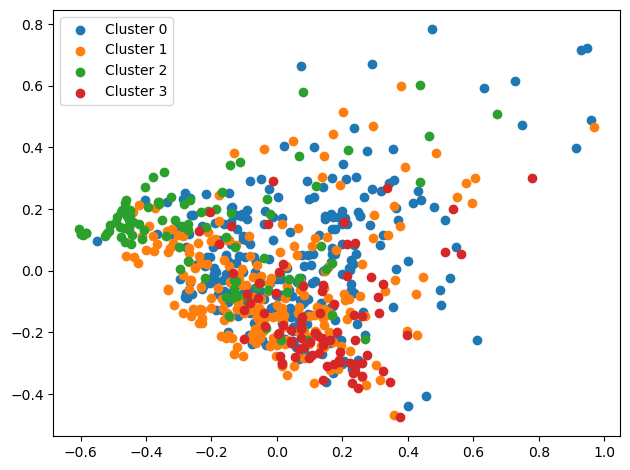

In [103]:
N = 4
clusters = KModes(n_clusters=N,init='Huang',n_init=5,random_state=None).fit(data).labels_

for n in range(N):
    X = transformed[:,0][clusters == n]
    Y = transformed[:,1][clusters == n]
    plt.scatter(X,Y,label=f'Cluster {n}')

plt.legend()
plt.tight_layout()

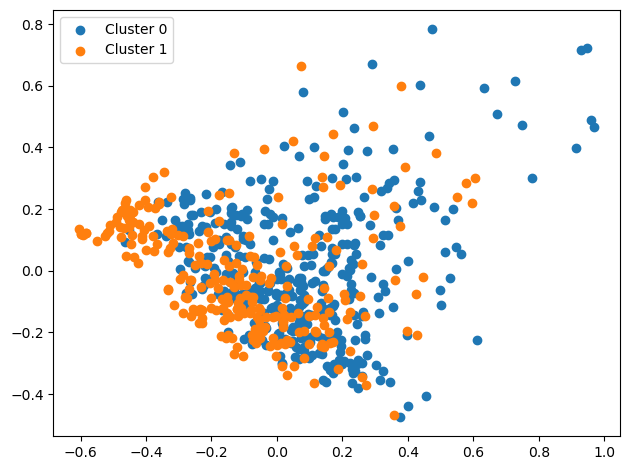

In [104]:
N = 2
clusters = KModes(n_clusters=N,init='Huang',n_init=5,random_state=None).fit(data).labels_

for n in range(N):
    X = transformed[:,0][clusters == n]
    Y = transformed[:,1][clusters == n]
    plt.scatter(X,Y,label=f'Cluster {n}')

plt.legend()
plt.tight_layout()

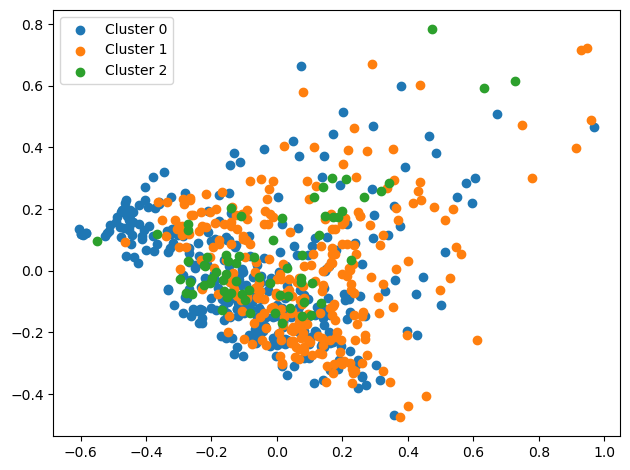

In [105]:
N = 3
clusters = KModes(n_clusters=N,n_init=5,random_state=None).fit(data).labels_

for n in range(N):
    X = transformed[:,0][clusters == n]
    Y = transformed[:,1][clusters == n]
    plt.scatter(X,Y,label=f'Cluster {n}')

plt.legend()
plt.tight_layout()

## Everything below here is just experimentation and can probably be ignored

In [106]:
data = data_customers[['marital_status','income', 'age', 'years_with_bank', 'nbr_children', 'gender',
                       'total_balance', 'has_savings_acct', 'has_credit_card',
                       'has_checking_acct', 'max_deposit', 'avg_deposit', 'max_withdrawal',
                       'avg_withdrawal', 'avg_trans_per_year']]

data = data[data.avg_trans_per_year > 0]

status = { 1:'A', 2:'B', 3:'C', 4:'D' }
gender = { 0:'M', 1:'F' }

data['marital_status'] = [ status[x] for x in data.marital_status ]
data['gender'] =  [ gender[x] for x in data.gender ]

data.columns = ['married','income', 'age', 'years', 'children', 'gender',
                'balance', 'savings', 'credit', 'checking', 'depMax', 'debAvg',
                'wdMax', 'wdAvg', 'transPerYear']

mca = MCA(n_components=2, n_iter=5, copy=True, check_input=True, engine='auto', random_state=None)

mca.fit(data)

mca.plot_coordinates(X=data)

ValueError: All values in X should be positive

In [ ]:
famd = FAMD(n_components=2, n_iter=5, copy=True, check_input=True, engine='auto', random_state=None)

famd.fit(data)

In [ ]:
coordinates = famd.row_coordinates(data)

In [ ]:
N = 3
clusters = KModes(n_clusters=N,init='Huang',n_init=5,random_state=None).fit(data).labels_

for n in range(N):
    X = coordinates[0][clusters == n]
    Y = coordinates[1][clusters == n]
    plt.scatter(X,Y,label=f'Cluster {n}')

plt.legend()
plt.tight_layout()

In [ ]:
for accounts in customer_to_accounts.values():
    if len(accounts) != len(set(accounts)):
        print(accounts)

In [ ]:
data_customers